In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

# data preprocessing

In [2]:
train_dir = "../../datasets/data2.5k"
validation_dir = "../../datasets/data2.5k"

In [3]:
batch_size = 32
image_size = (256, 256)

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_size),
  batch_size=batch_size
)

Found 2500 files belonging to 5 classes.
Using 2000 files for training.


In [7]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
  validation_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_size),
  batch_size=batch_size
)

Found 2500 files belonging to 5 classes.
Using 500 files for validation.


['CBB', 'CBSD', 'CGM', 'CH', 'CMD']


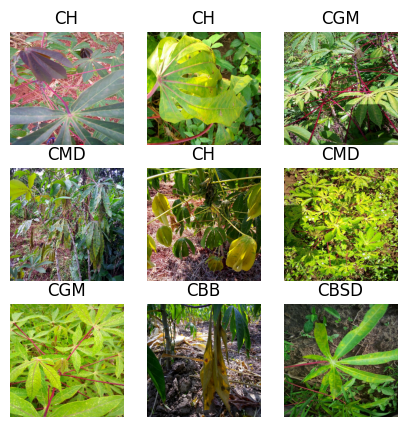

In [8]:
class_names = train_dataset.class_names
print(class_names)

plt.figure(figsize=(5, 5))
for images, labels in train_dataset.take(1):
  for i in range(9):
   ax = plt.subplot(3, 3, i + 1)
   plt.imshow(images[i].numpy().astype("uint8"))
   plt.title(class_names[labels[i]])
   plt.axis("off")

In [9]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [10]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 13
Number of test batches: 3


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

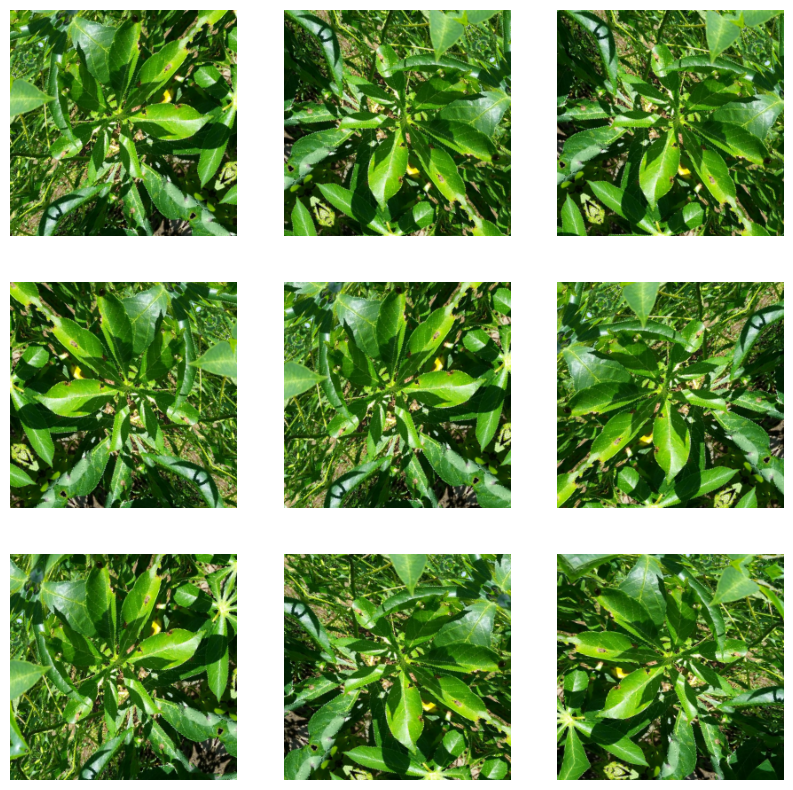

In [13]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [15]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [16]:
# Create the base model from the pre-trained model MobileNet V2
image_shape = image_size + (3,)
base_model = tf.keras.applications.MobileNetV2(
   input_shape=image_shape,
   include_top=False,
   weights='imagenet'
)

In [19]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 1280)


In [20]:
base_model.trainable = False

In [21]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [22]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [23]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [24]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                             

In [26]:
len(model.trainable_variables)

2

In [27]:
base_learning_rate = 0.0001
model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
   loss=tf.keras.losses.BinaryCrossentropy(),
   metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')]
)

In [28]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

13/13 [==============================] - 1s 45ms/step - loss: 2.2418 - accuracy: 0.2252


In [29]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.24
initial accuracy: 0.23


In [30]:
history = model.fit(
   train_dataset,
   epochs=initial_epochs,
   validation_data=validation_dataset
)

Epoch 1/10
63/63 [==============================] - 11s 121ms/step - loss: 0.1274 - accuracy: 0.1875 - val_loss: -1.2280 - val_accuracy: 0.1906
Epoch 2/10
63/63 [==============================] - 8s 118ms/step - loss: -2.8318 - accuracy: 0.2020 - val_loss: -3.5010 - val_accuracy: 0.2054
Epoch 3/10
63/63 [==============================] - 8s 118ms/step - loss: -5.2143 - accuracy: 0.2015 - val_loss: -5.8663 - val_accuracy: 0.1955
Epoch 4/10
63/63 [==============================] - 8s 118ms/step - loss: -7.5010 - accuracy: 0.2015 - val_loss: -7.7923 - val_accuracy: 0.1881
Epoch 5/10
63/63 [==============================] - 8s 118ms/step - loss: -9.7954 - accuracy: 0.2015 - val_loss: -10.2772 - val_accuracy: 0.1782
Epoch 6/10
63/63 [==============================] - 8s 122ms/step - loss: -12.2590 - accuracy: 0.2015 - val_loss: -11.9916 - val_accuracy: 0.1906
Epoch 7/10
63/63 [==============================] - 8s 122ms/step - loss: -14.7078 - accuracy: 0.2015 - val_loss: -14.4518 - val_accu

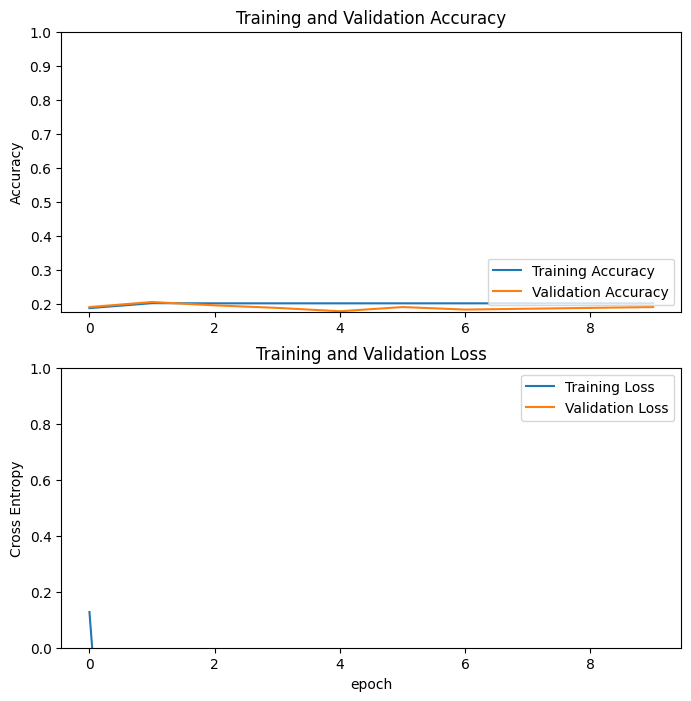

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [32]:
base_model.trainable = True

In [33]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [34]:
model.compile(
   loss=tf.keras.losses.BinaryCrossentropy(),
   optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
   metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')]
)

In [35]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                             

In [36]:
len(model.trainable_variables)

56

In [37]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(
   train_dataset,
   epochs=total_epochs,
   initial_epoch=len(history.epoch),
   validation_data=validation_dataset
)

Epoch 11/20
63/63 [==============================] - 14s 148ms/step - loss: -264.9729 - accuracy: 0.2015 - val_loss: -337.1556 - val_accuracy: 0.2005
Epoch 12/20
63/63 [==============================] - 12s 185ms/step - loss: -379.7345 - accuracy: 0.2015 - val_loss: -371.3535 - val_accuracy: 0.1807
Epoch 13/20
63/63 [==============================] - 9s 137ms/step - loss: -389.7148 - accuracy: 0.2015 - val_loss: -348.6355 - val_accuracy: 0.2079
Epoch 14/20
63/63 [==============================] - 9s 134ms/step - loss: -396.9156 - accuracy: 0.2015 - val_loss: -379.4456 - val_accuracy: 0.1906
Epoch 15/20
63/63 [==============================] - 9s 133ms/step - loss: -404.5672 - accuracy: 0.2015 - val_loss: -385.8084 - val_accuracy: 0.1881
Epoch 16/20
63/63 [==============================] - 8s 133ms/step - loss: -411.8343 - accuracy: 0.2015 - val_loss: -401.3377 - val_accuracy: 0.1757
Epoch 17/20
63/63 [==============================] - 9s 143ms/step - loss: -418.3317 - accuracy: 0.2015 

In [38]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

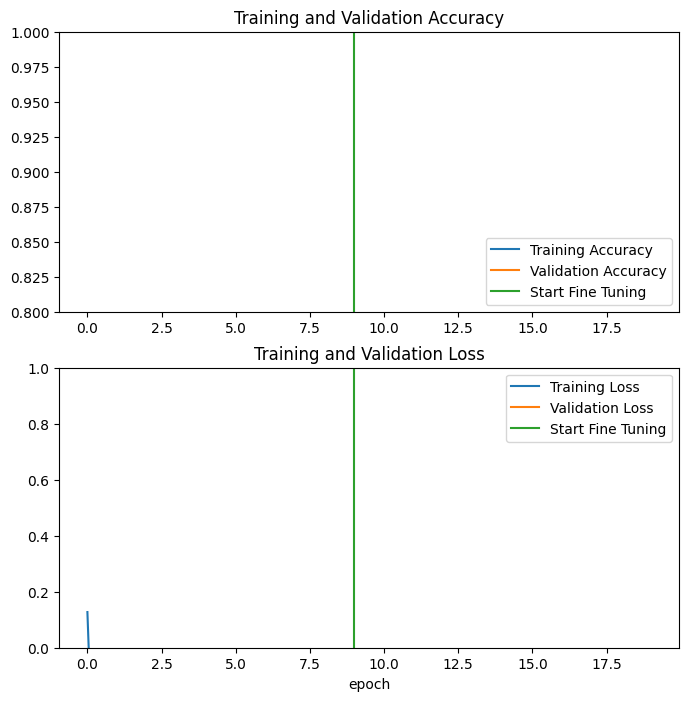

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [40]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

3/3 [==============================] - 0s 44ms/step - loss: -425.4681 - accuracy: 0.2708
Test accuracy : 0.2708333432674408


Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [4 2 4 1 4 0 3 2 0 3 4 2 4 3 2 2 1 0 0 0 0 2 3 0 1 2 3 4 2 2 0 4]


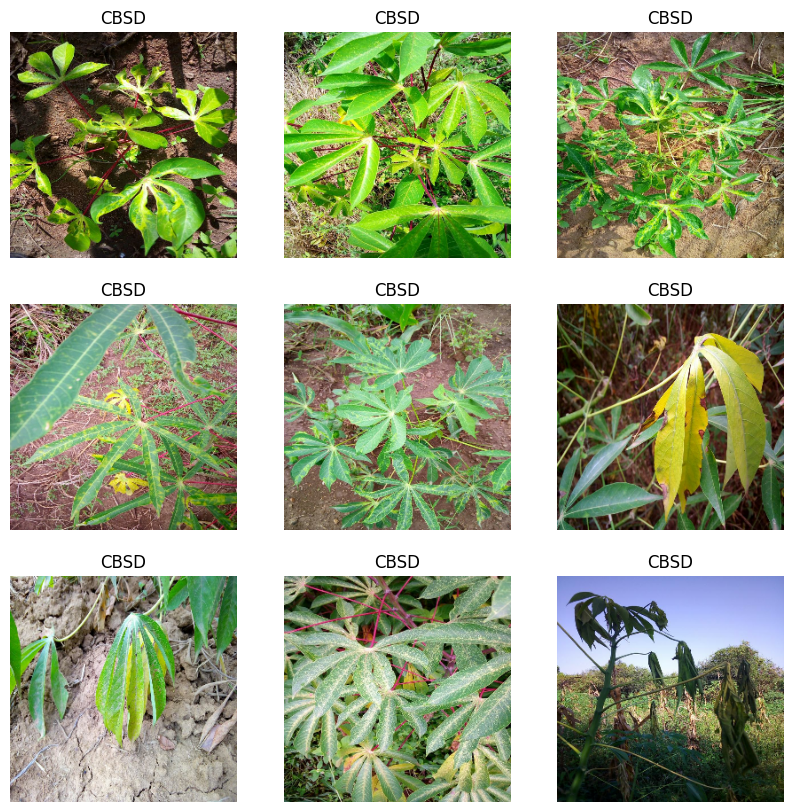

In [41]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")